In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive

!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py
import resnet_cifar10_v2

drive.mount('/content/drive/')
loc = 'drive/MyDrive/Shtem2023/'
print(os.listdir(loc+'/all_data'))

Sourced from https://keras.io/examples/vision/simsiam/

In [ ]:

##########    THIS IS THE ONLY CELL YOU NEED TO CHANGE :) ################
dataset_name = 'breastcancer'

X = np.load(loc+'/all_data/'+dataset_name+'X.npy')
Y = np.load(loc+'/all_data/'+dataset_name+'Y.npy')
Ntrain = 800 # make sure Ntrain + Ntest < dataset size!!!!! # WANT NTRAIN ~ 200-1000
littleNtrain = 160
num_cat = 2
CROP_TO = 250

In [ ]:
print(X.shape, Y.shape)
dataset_size = X.shape[0]
print(dataset_size)

(979, 250, 250, 3) (979, 2)
979


In [ ]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 8 # maybe up to 256 # lol no, don't change from 8
Ntest = 208
SEED = 26
EPOCHS = 15
PROJECT_DIM = 128
LATENT_DIM = 64
WEIGHT_DECAY = 0.0005
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_train, y_train, x_test, y_test  = X[:Ntrain], Y[:Ntrain], X[-Ntest:], Y[-Ntest:]

In [ ]:
### PICTURE EDITING FUNCTIONS

def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image

def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x

def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x

def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x

def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image

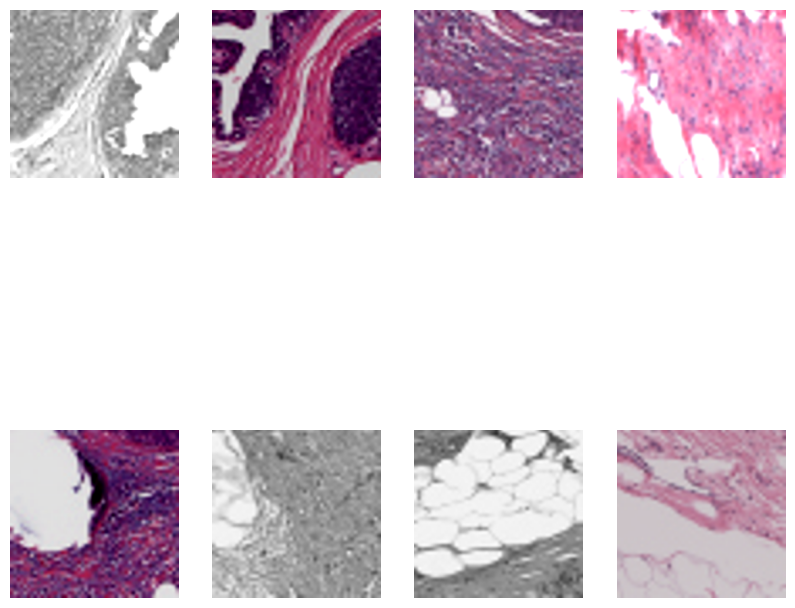

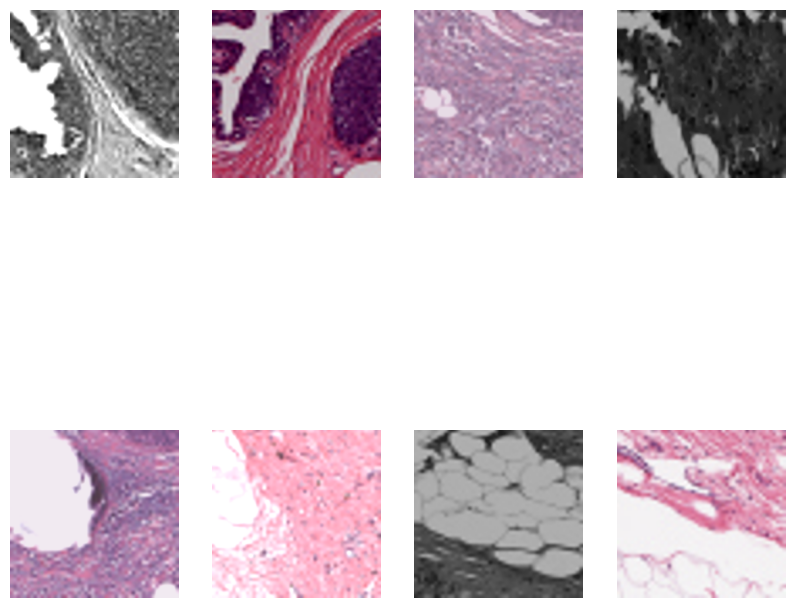

In [ ]:
# 1800 DONT LOOK AT THIS, ITS JUST FANCY MAKING TRAIN SET AND TEST SET

ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(8):
    ax = plt.subplot(2, 4, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(8):
    ax = plt.subplot(2, 4, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

In [ ]:
N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1

def get_encoder():
    # Input and backbone.
    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    x = resnet_cifar10_v2.stem(x)
    x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name="encoder")

def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model

In [ ]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))

In [ ]:
class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super().__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [ ]:
### SELF LEARNING

# Create a cosine decay learning scheduler.
num_training_samples = len(x_train)
steps = EPOCHS * (num_training_samples // BATCH_SIZE)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.03, decay_steps=steps
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=15, restore_best_weights=True
)

# Compile model and start training.
simsiam = SimSiam(get_encoder(), get_predictor())
simsiam.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
ssHistory = simsiam.fit(ssl_ds, epochs=EPOCHS, callbacks=[early_stopping])

# Visualize the training progress of the model.
plt.plot(ssHistory.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()

pd.DataFrame(ssHistory.history).to_csv(loc + "Results/cosineLoss_" + str(Ntrain) + "_" + dataset_name + ".csv")

print('SELF SUPERVISED RESULTS SAVED!!!\n'*4)

Epoch 1/15
100/100 [==============================] - 2129s 21s/step - loss: -0.8992
Epoch 2/15
100/100 [==============================] - 2090s 21s/step - loss: -0.9304
Epoch 3/15
100/100 [==============================] - 2043s 20s/step - loss: -0.9238
Epoch 4/15
100/100 [==============================] - 2017s 20s/step - loss: -0.9238
Epoch 5/15
100/100 [==============================] - 1968s 20s/step - loss: -0.9255
Epoch 6/15
100/100 [==============================] - 1951s 19s/step - loss: -0.9326
Epoch 7/15
100/100 [==============================] - 1955s 20s/step - loss: -0.9389
Epoch 8/15
100/100 [==============================] - 1960s 20s/step - loss: -0.9417
Epoch 9/15
100/100 [==============================] - 1940s 19s/step - loss: -0.9476
Epoch 10/15
100/100 [==============================] - 1944s 19s/step - loss: -0.9481
Epoch 11/15
100/100 [==============================] - 1977s 20s/step - loss: -0.9501
Epoch 12/15
100/100 [==============================] - 1970s 20

In [ ]:
# We first create labeled `Dataset` objects.
#### TESTING PERFORMANCE OF SELF LEARNING WITH LABELS


x_train, y_train, x_test, y_test  = X[:littleNtrain], Y[:littleNtrain], X[-Ntest:], Y[-Ntest:]

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
backbone.trainable = False # locking self learning in place
inputs = layers.Input((CROP_TO, CROP_TO, 3))

x = backbone(inputs, training=False)
x = layers.Dropout(.125)(x)
x = layers.Dense(32, activation= "tanh")(x) #add more of these??? maybe change the cell count???
x = layers.BatchNormalization()(x)
x = layers.Dropout(.1)(x)
x = layers.Dense(32, activation= "tanh")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(.1)(x)
x = layers.Dense(32, activation = "sigmoid")(x)

outputs = layers.Dense(num_cat, activation="softmax")(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.9),
)
linear_model.summary()
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping]
)
#_, test_acc = linear_model.evaluate(test_ds)
#print("Test accuracy: {:.2f}%".format(test_acc * 100))
pd.DataFrame(history.history).to_csv(loc + "Results/self_" + str(Ntrain) + "_" + str(littleNtrain) + "_" + dataset_name + ".csv")
print('TRAINING RESULTS SAVED!!!\n'*4)